# **Homework 12 - Reinforcement Learning**




## Preliminary work
## 准备工作

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.  
  
首先，我们需要安装一堆包。其中gym包是用来实现RL的算法的，其他都是用来可视化的。


In [57]:
!apt update
!pip install swig
!apt install python-opengl xvfb -y
!pip install pyvirtualdisplay 
!pip install gym[box2d]

#!pip install gym

#tqdm numpy==1.19.5 torch==1.8.1

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
40 packages can be upgraded. Run 'apt list --upgradable' to see them.
Looking in indexes: https://pypi.org/simple, https://us-python.


Next, set up virtual display，and import all necessaary packages.
  
import一堆包，并设置可视化页面

In [58]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

%%capture
import gym
import random


#https://www.gymlibrary.dev/content/basic_usage/  gym库

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.

  
助教不允许我们用随机种子


In [59]:
#固定种子

seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  #torch.set_deterministic(True)
  #这行不知道为什么运行不了，可能和pytorch版本有关
  torch.use_deterministic_algorithms(True)
  #应改成这句 

  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.
  
使用gym，建立“Lunar Lander”环境

In [60]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

# 建立一个环境

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.  


This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment". 

In this homework, we will utilize the function `step()` to control the action of "Agent". 

Then `step()` will return the observation/state and reward given by the "Environment".  


  
这玩意是用来模拟飞行器降落在月球表面的情况的东西。  
其目标是让飞行器安全地在两个黄旗子之间的垫子上着陆
> 着陆垫始终在坐标（0，0）处  
> 坐标是state vector（状态向量）的前两个数字？
  
  
"LunarLander-v2"已经集成了“Agent”和“Environment”  
在本次作业中，我们要使用step（）函数去控制“Agent”的行动  
然后step（）会返回observation和环境的reward。



# 官方文档中的信息
[文档](https://www.gymlibrary.dev/environments/box2d/lunar_lander/)

##Actions：
四种
- 0代表agent啥也不做   
- 1、2、3代表左边、向下、右边引擎开火（喷射）
  
##Observation space: 
八维向量，例如[1.5 1.5 5. 5. 3.14 5. 1. 1. ]  
分别代表[坐标x，坐标y，x方向分速度，y方向分速度，角度，角速度，bool，bool]  
两个bool表示飞行器的两只脚是否着陆。

##Reward:
登陆垫始终在（0，0）。坐标是状态向量（那个八维向量）的前两维。 从屏幕顶端到达登陆垫并保持速度为0的reward是大概100-140pt。如果登陆器从登陆垫上移动出去了，reward就没了。当登陆器被摧毁了（-100pt）或者成功着陆并休息后（+100pt），一个episode结束。登陆器的每条腿接触地面会+10pt。 主引擎点火为每帧-3分。 解决了加200分

-在黄旗之间着陆    +100-140pt
-着陆但移动出去了  上边的pt没了
-坠毁           -100pt
-主引擎点火(向下喷射) 每帧-0.3pt
-左右引擎点火.    每帧-0.03pt
-登陆器最终静止(rest)  再+100pt
-每条腿接触地面.      +10pt

-解决了（solved）（？）  +200pt

  
## Starting State
The lander starts at the top center of the viewport with a random initial force applied to its center of mass.  
着陆器

## Episode Termination
  



# Observation / State

First, we can take a look at what an Observation / State looks like.  
Observation长下边这样

In [61]:
print(env.observation_space)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like  
Action长下边这样

In [62]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment. 
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.
  
这表明一共有四种行动。  
- 0代表agent啥也不做  
- 2代表它向下加速  
- 1、3代表它左移和右移  
  
下边我们将会尝试让agent与环境互动  
在agent采取行动之前，我们推荐用reset（）去reset环境，这个函数也会返回环境的初始状态

In [63]:
initial_state = env.reset()
print(initial_state)

#初始环境长下边这样，和Box一样，也是八维向量

[-1.2619973e-03  1.3984586e+00 -1.2784091e-01 -5.5384123e-01
  1.4691149e-03  2.8957864e-02  0.0000000e+00  0.0000000e+00]


Then, we try to get a random action from the agent's action space.  
然后，我们将试着随机得到一种行动

In [64]:
random_action = env.action_space.sample()
print(random_action)

3


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information  

下边，我们可以用step（）去使agent按照上边随机抽取的random_action进行行动  
step（）将会返回四个值：  
- observation / state
- reward
- done (True/ False)
- Other information  

In [65]:
observation, reward, done, info = env.step(random_action)

In [66]:
print(observation, reward, done, info)
print(type(observation), type(reward),type( done), type(info))
#[-2.4652481e-03  1.3854232e+00 -1.2026372e-01 -5.7935303e-01,1.4148270e-03 -1.0852187e-03  0.0000000e+00  0.0000000e+00] 
# -1.0511407416545058 False {}

# <class 'numpy.ndarray'> <class 'numpy.float64'> <class 'bool'> <class 'dict'>

[-2.4652481e-03  1.3854232e+00 -1.2026372e-01 -5.7935303e-01
  1.4148270e-03 -1.0852187e-03  0.0000000e+00  0.0000000e+00] -1.0511407416545058 False {}
<class 'numpy.ndarray'> <class 'numpy.float64'> <class 'bool'> <class 'dict'>


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points.   

登陆垫始终在（0，0）。坐标是状态向量（那个八维向量）的前两维。 从屏幕顶端到达登陆垫并保持速度为0的reward是大概100-140pt。如果登陆器从登陆垫上移动出去了，reward就没了。当登陆器被摧毁了（-100pt）或者成功着陆并休息后（+100pt），一个episode结束。登陆器的每条腿接触地面会+10pt。 主引擎点火为每帧-3分。 解决了（？）加200分

In [67]:
print(reward)

-1.0511407416545058


# Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.  
在开始训练之前，我们可以看看一个随机生成的agent是否能够成功地着陆

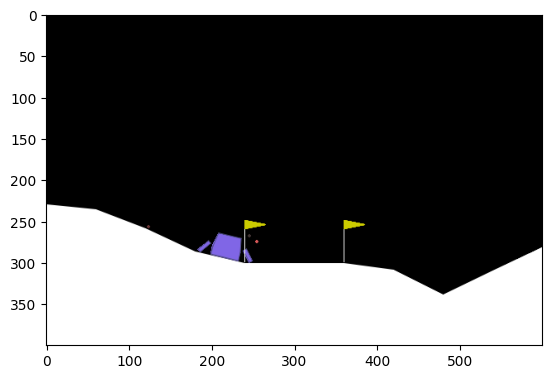

In [68]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
  action = env.action_space.sample()
  #Randomly sample an element of this space.
  #随机抽取动作空间里的一个元素
  observation, reward, done, _ = env.step(action)
  img.set_data(env.render(mode='rgb_array'))
  display.display(plt.gcf())
  display.clear_output(wait=True)
  #一帧一帧的渲染下边的图像，直到完成一轮为止
    



    

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.  
现在，我们将创建一个简单的policy network，它将返回一项动作。

In [69]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

        #三层线性层 8=>16=>16=>4
        #输入是八维的状态向量（state），输出是四维，代表四个动作

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

        #两次tanh一次softmax
        #8=>16=>tanh=>16=>tanh=>4=>softmax=>output
        

## Softmax中的dim:
-  dim=0 对第一个坐标轴的所有元素进行softmax运算，并使得每一列所有元素和为1
-  dim=1 对第二个坐标轴的所有元素进行softmax运算，并使得每一行所有元素和为1
-  dim=2 对第三个坐标轴的所有元素进行softmax运算，并使得每一行所有元素和为1
  
  以此类推
-  dim=-1 对第倒数第一个坐标轴的所有元素进行softmax运算，并使得每一行所有元素和为1


In [70]:
import torch
import torch.nn.functional as F
input = torch.randn(2,2)
print(input)
m = F.softmax(input,dim=0)
print("dim=0",m)
m = F.softmax(input,dim=1)
print("dim=1",m)
#m = F.softmax(input,dim=2)
#print("dim=2",m)
m = F.softmax(input,dim=-1)
print("dim=-1",m)

tensor([[-1.9000,  1.0630],
        [ 0.1354, -0.3442]])
dim=0 tensor([[0.1155, 0.8033],
        [0.8845, 0.1967]])
dim=1 tensor([[0.0491, 0.9509],
        [0.6176, 0.3824]])
dim=-1 tensor([[0.0491, 0.9509],
        [0.6176, 0.3824]])


## Agent
Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities.  
  
下边，我们需要创建一个简单的agent。它能够做以下事情：  
- learn（）：使用log probabilities and rewards来更新policy network  
- sample（）：在接收observation后，使用policy network去告诉agent下边需要采取哪种行动，这个函数的返回值包括行动和log probabilities

In [71]:
from torch.optim.lr_scheduler import StepLR
class PolicyGradientAgent():
    
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)
        #优化算法：SGD
        
    def forward(self, state):
        return self.network(state)
    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum() 

        # You don't need to revise this to pass simple baseline (but you can)
        #你无需修改loss算法就可以通过simple baseline，但是你可以改

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        #把state传给network，并接受动作的概率
        action_dist = Categorical(action_prob)
        #Categorical类
        action = action_dist.sample()
        #按照概率随机抽取一个动作
        #比如[0.1,0.3,0.2,0.4],会按照这个概率表在0-3之间抽取一个动作
        log_prob = action_dist.log_prob(action)
        #取log的概率
        return action.item(), log_prob
        #返回action种类，和log probability

## Categorical
CLASS   
torch.distributions.categorical.Categorical(probs=None, logits=None, validate_args=None)  


In [72]:
import torch
from torch.distributions.categorical import Categorical




def printf(sample_prob):
  sample_prob=torch.FloatTensor(sample_prob)
  #AttributeError: 'list' object has no attribute 'dim'
  sample_dist = Categorical(sample_prob)
  sample_action = sample_dist.sample()
  sample_log_prob = sample_dist.log_prob(sample_action)
  sample_prob_cate = sample_dist.probs
  print(sample_dist)
  print(sample_action)
  print(type(sample_action))
  print(sample_log_prob)
  print(sample_prob_cate)
  print("#########################")





printf([0.1,0.3,0.2,0.4]) 
# sum=1 log=[-2.3,-1.2,-1.6,-0.9]
#printf([0.1,0.3,0.2,0.3]) # sum=0.9



'''
一次输出
[0.1,0.3,0.2,0.4]
Categorical(probs: torch.Size([4]), logits: torch.Size([4]))
tensor(3)
tensor(-0.9163)
log(0.2)=
'''

Categorical(probs: torch.Size([4]), logits: torch.Size([4]))
tensor(3)
<class 'torch.Tensor'>
tensor(-0.9163)
tensor([0.1000, 0.3000, 0.2000, 0.4000])
#########################


'\n一次输出\n[0.1,0.3,0.2,0.4]\nCategorical(probs: torch.Size([4]), logits: torch.Size([4]))\ntensor(3)\ntensor(-0.9163)\nlog(0.2)=\n'

In [73]:
import torch
from torch.distributions.categorical import Categorical
l_tongji = [0,0,0,0]

sample_prob=torch.FloatTensor([0.1,0.3,0.2,0.4])
sample_dist = Categorical(sample_prob)
for x in range(100000):
  sample_action = sample_dist.sample()
  if sample_action == torch.Tensor([0]):
    l_tongji[0]+=1
  if sample_action == torch.Tensor([1]):
    l_tongji[1]+=1
  if sample_action == torch.Tensor([2]):
    l_tongji[2]+=1
  if sample_action == torch.Tensor([3]):
    l_tongji[3]+=1
print(l_tongji)

# [10098, 30215, 20053, 39634]

[10066, 29792, 20108, 40034]


## 实例化
Lastly, build a network and agent to start training.  
最后，创建（实例化）一个network和agent，然后开始训练！

In [74]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,  
  
下边我们开始训练agent了 
通过把agent和环境间的所有互动当作训练数据，policy network可以从所有的attempts中学习


In [75]:
agent.network.train()  
# Switch network into training mode 
# 转换为train模式 
EPISODE_PER_BATCH = 5  
# update the  agent every 5 episode
# 每5个episode更新一次agent

NUM_BATCH = 500        
# totally update the agent for 400 time（？）
# 一共更新500次

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))

flag_print = 0
#控制显示的条数，防止浏览器卡死

#Medium: accumulative decaying reward
def accu_decay_reward(rewards):
  accu_reward = 0
  decay = 0.99 #衰减因子
  rewards_len = len(rewards)
  accu_rewards = [0]*(rewards_len + 1)

  for x in range(rewards_len):
    accu_rewards[rewards_len-1-x] = decay*accu_rewards[rewards_len-x] + rewards[rewards_len-1-x]
  del(accu_rewards[-1])
  #print(accu_rewards)
  return accu_rewards
  
    



for batch in prg_bar:
# 500个batch

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # collect trajectory
    for episode in range(EPISODE_PER_BATCH):
      #每个batch有5个episode
        
        state = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:

            action, log_prob = agent.sample(state) 
            # at, log(at|st)
            #动作种类和这一动作的log概率
            next_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            #存储log_prob

            # seq_rewards.append(reward)
            state = next_state
            total_reward += reward
            total_step += 1
            #更新参数

            rewards.append(reward) # change here
            #TODO：需要改变的部分
            
            # ! IMPORTANT !
            # Current reward implementation: immediate reward,  
            # given action_list : a1, a2, a3 ......
            #  rewards :     r1, r2 ,r3 ......
            # medium：change "rewards" to accumulative decaying reward, 
            # given action_list : a1,a2,a3, ......
            # rewards :   r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,  r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement Actor-Critic

            #目前的：只存储当前的reward
            #medium：积累延迟reward
            #boss：采用Actor-Critic

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break
            #一个episode完成后，记录final reward和total reward


    if flag_print%100==0:
      print(f"rewards looks like ", np.shape(rewards))
    #log_probs_shape = np.array(log_probs).detach().shape
    #AttributeError: 'list' object has no attribute 'shape'
    #RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.
    #print(f"log_probs looks like ", np.shape(log_probs)) 
      print(f"log_probs looks like ", log_probs) 
    
    #源代码每完成一个batch就要显示一大堆信息，容易卡死，这里让它只显示一次


    # record training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")
    #计算平均的total和final reward，并显示这俩

    # update agent 更新agent
    # rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  
    # normalize the reward  标准化reward
    # std：标准差

    accu_rewards=accu_decay_reward(rewards)

    #agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))

    agent.learn(torch.stack(log_probs), torch.tensor(accu_rewards))
    #调用learn()更新agent
    #torch.from_numpy()把numpy中的向量转化为torch中的张量，共享内存空间
    #torch.stack()拼接张量，不太清楚这里是怎么拼接的



    if flag_print%100==0:
      print("logs prob looks like ", torch.stack(log_probs).size())
      print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())
      flag_print+=1
    #显示信息x2




  0%|          | 0/500 [00:00<?, ?it/s]

rewards looks like  (497,)
log_probs looks like  [tensor(-1.5980, grad_fn=<SqueezeBackward1>), tensor(-1.5968, grad_fn=<SqueezeBackward1>), tensor(-1.3206, grad_fn=<SqueezeBackward1>), tensor(-1.5973, grad_fn=<SqueezeBackward1>), tensor(-1.5960, grad_fn=<SqueezeBackward1>), tensor(-1.5948, grad_fn=<SqueezeBackward1>), tensor(-1.5333, grad_fn=<SqueezeBackward1>), tensor(-1.5884, grad_fn=<SqueezeBackward1>), tensor(-1.3194, grad_fn=<SqueezeBackward1>), tensor(-1.5340, grad_fn=<SqueezeBackward1>), tensor(-1.1654, grad_fn=<SqueezeBackward1>), tensor(-1.1631, grad_fn=<SqueezeBackward1>), tensor(-1.5891, grad_fn=<SqueezeBackward1>), tensor(-1.1629, grad_fn=<SqueezeBackward1>), tensor(-1.1612, grad_fn=<SqueezeBackward1>), tensor(-1.3203, grad_fn=<SqueezeBackward1>), tensor(-1.5942, grad_fn=<SqueezeBackward1>), tensor(-1.1614, grad_fn=<SqueezeBackward1>), tensor(-1.3199, grad_fn=<SqueezeBackward1>), tensor(-1.1575, grad_fn=<SqueezeBackward1>), tensor(-1.3205, grad_fn=<SqueezeBackward1>), tenso

In [76]:
rewards = [1,1,1,1,1,1,1,1,1,1]
def accu_decay_reward(rewards):
  accu_reward = 0
  decay = 0.99 #衰减因子
  rewards_len = len(rewards)
  accu_rewards = [0]*(rewards_len + 1)

  for x in range(rewards_len):
    accu_rewards[rewards_len-1-x] = decay*accu_rewards[rewards_len-x] + rewards[rewards_len-1-x]
  del(accu_rewards[-1])
  print(accu_rewards)
  return accu_rewards
print(accu_decay_reward(rewards))

[9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.9403989999999998, 2.9701, 1.99, 1.0]
[9.561792499119552, 8.64827525163591, 7.72553055720799, 6.793465209301, 5.8519850599, 4.90099501, 3.9403989999999998, 2.9701, 1.99, 1.0]


### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  
  

###训练结果  
通过训练过程，我们记录了“avg_total_reward”,它表示在更新policy network之前的平均的total reward  
理论上，如果agent变好了，那么avg_total_reward也会增加。  
训练过程的可视化图像见下

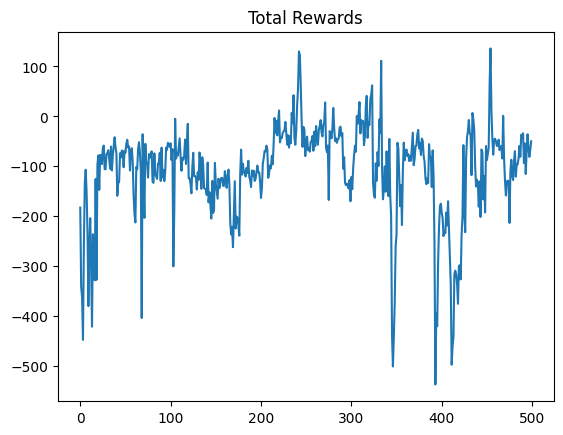

In [77]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

#横坐标为batch，纵坐标为avg_total_rewards

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.  
  
另外，avg_final_reward代表了每个episode的平均final reward  
特别的，final reward是一个episode中最后一次获得的reward，表明飞行器是否成功着陆


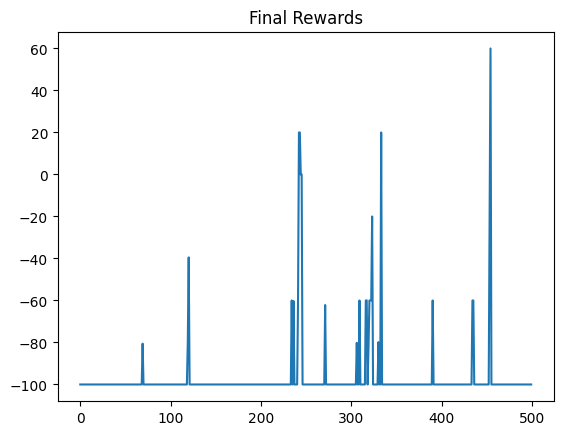

In [78]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

#横坐标为batch，纵坐标为avg_final_rewards

## Testing
The testing result will be the average reward of 5 testing  
测试结果是五次测试(5个episode，1个batch)的reward的平均值

-113.22163001595175
-60.10639732850657


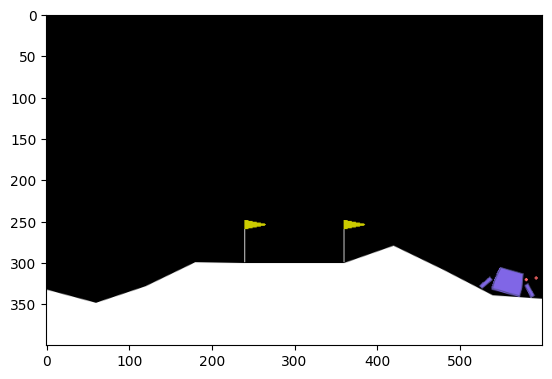

In [79]:
#测试部分和训练部分基本一样

fix(env, seed)
agent.network.eval()  # set the network into evaluation mode  改成evaluation mode
NUM_OF_TEST = 5 # Do not revise this !!!  不要更改！！！
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action, _ = agent.sample(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      img.set_data(env.render(mode='rgb_array'))
      display.display(plt.gcf())
      display.clear_output(wait=True)
      
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing 
  print(np.mean(test_total_reward))


## 示例部分
Action list  
动作列表

In [80]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

# 5代表5次episode

Action list looks like  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 3, 1, 1, 2, 2, 0, 1, 3, 2, 2, 1, 1, 3, 3, 2, 2, 1, 2, 1, 2, 2, 2, 1, 3, 2, 1, 3, 2, 2, 3, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 3, 2, 3, 3, 3], [3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 3, 1, 3, 2, 1, 

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Analysis of actions taken by agent  
agent的动作分析

就是统计了一下上边action list里边各种动作的数目

In [81]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{3: 124, 0: 11, 1: 146, 2: 114}


Saving the result of Model Testing  
保存测试的结果


In [82]:
PATH = "Action_List.npy" # Can be modified into the name or path you want
np.save(PATH ,np.array(action_list)) 

<ipython-input-82-fd322f3df017>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(PATH ,np.array(action_list))


### This is the file you need to submit !!!
Download the testing result to your device  
需要提交的文件



In [83]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Server 
The code below simulate the environment on the judge server. Can be used for testing.
  
下边的代码模拟了judge系统上的环境，可以用来测试

Your reward is : -43.29
Your reward is : -74.39
Your reward is : -84.38
Your reward is : 14.75
Your reward is : -113.22


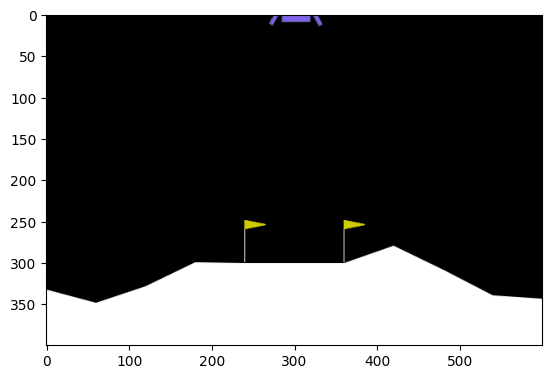

In [84]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 543 # Do not revise this
fix(env, seed)

agent.network.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  for action in actions:
  
      state, reward, done, _ = env.step(action)
      total_reward += reward
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# Your score

In [85]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : -60.11


## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
